# PyODEM Framework - Introduction

This Notebook will help guide you through fitting the epsilon parameters of a protein structure based model using the new pyODEM package. The package is designed so that the "heavy lifting" (e.g. maximum likelihood estimation) is automated, while the loading of data files is done by the user through the creation of several objects.

The over-arching goal is to take adjust the parameters (epsilon) of a CG-model's Hamiltonian so that the observables the CG model produces matches the observables from some Reference model. This is done iteratively in cycles of "Simulate -> Optimize -> Simulate -> Optimize..." until a reasonable agreement between the CG-model observables with the Reference-model observables. Hopefully, the Reference model will simply be real experimental data in the future, but for now we are using an all-atom simulation as a Reference model in order to properly interpret the resultant distribution. 

As an example, we are going to take the FiP35 ww-domain protein as an example test case. The Reference observables were previously generated from an all-atom model of FiP35, simulated by the D.E. Shaw group. The results of the analysis is included in the folders entitled "distance", "enhance" and "q_analysis". The tutorial will be divided into Three steps. First, a simulation of the coarse-grained model is simulated using the structure-based modeling package from the Onuchic group. Second, some preparation steps are run mainly to prepare observables for analysis while also partitioning the trajectory into discrete clusters of states. In particular, understanding how the partitioning of the trajectory into discrete states occurs would benefit greatly from reviewing the tutorials on the pyEMMA package available form the Noe group in Berlin <http://emma-project.org/latest/ipython.html>. And finally, the last section will deal with setting up a and using the pyODEM to find a new set of parameters for the "optimize" step, and then save those new parameters to re-start the "simulate" step. All the work in these three sections is to eventually set up the maximum_likelihood object which will be near the end of the final section, expressed as:

```
solutions = pyODEM.estimators.max_likelihood_estimate(data_formatted, dtrajs, obs, 
    pmodel, stationary_distributions=stationary_distribution, obs_data=obs_data, 
    solver="bfgs", logq=True, kwargs=function_args)
```

Furthermore, if you do not wish for simulations to complete to just test the package, you can copy the directory "example_2/pre_determined_results/iteration_0" to "example_2/iteration_0" and skip the step in Part I that involves making a shell call to GROMACS commands. 


## Prerequisites:
Before starting, please ensure the following pre-requisites are met:

#### Install
* pyEMMA : http://emma-project.org/latest/INSTALL.html

* generic python packages : numpy, scipy, os, mdtraj, shutil, ConfigParser, subprocess 

#### Clone
The following packages should be cloned into a directory called "code" and ensure ".../code" is in your PYTHONPATH variable:

* pyODEM : https://github.com/ClementiGroup/pyODEM

* model_builder : https://github.com/ajkluber/model_builder

* simulation : https://github.com/ajkluber/simulation

## Summary of Key Variables and Terms
Some key objects and methods are defined here for easy reference. 

### Vocbulary
* **AA model**: All-Atom model.
* **CG model**: Stands for Coarse-Grained model. A common abbreviation used throughout.
* **epsilon(s)**: The model parameter(s) that are being adjusted during the pyODEM framework. 
* **topology**: Can refer to two things. For `model_builder` it refers to the reference structure used to determine parameterize the backbone terms in the Hamiltonian. For GROMACS, it refers specifically to the .top file used for running simulations.


### Variable Names in Code:
#### Abbreviation on sizes:
* N: Number of frames in the trajectory
 
#### Final Objects Created
* `data_formatted`:
* `dtrajs`: 
* `obs`:
* `pmodel`:
* `stationary_distribution`:
* `obs_data`:
* `function_args`:


Once pre-requisites are installed/cloned and ready, the following code will import all the necessary packages. Any of the other missing packages can normally be installed using conda via `conda package`. Then we'll define a few shortcuts for easy access to methods later (`ml`, `observables`, `ene`), as well as `cwd` (current directory) for navigating the directory space inside python. As well as a method for saving ini files, the parameter file for the model_builder package interprets. These imports will be used throughout the tutorial, however not all packages will be used in all sections.

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#Generic Packages
import numpy as np
import scipy.stats as stats
import os
import mdtraj as md
import shutil
import configparser
import pyemma.coordinates as coor
import pyemma.msm as msm
import subprocess as sb
import simulation.gromacs.mdp as mdp_writer

#In house packages
import model_builder as mdb
import pyODEM


#Shortcuts
ml = pyODEM.model_loaders #sub-package with methods for loading using model_builder and formatting for pyODEM
observables = pyODEM.observables #sub-package for formatting observable information
ene = pyODEM.estimators.max_likelihood_estimate #method for running a max-likelihood estimate for new epsilons

def save_ini_file(inifile, newiter, newfile_location):
    config = ConfigParser.SafeConfigParser(allow_no_value=True)
    config.read(inifile)

    config.set("fitting", "iteration", str(newiter))
    newparams = "%s/model_params" % newfile_location
    newpairwise = "%s/pairwise_params" % newfile_location

    config.set("model", "pairwise_params_file", newpairwise)
    config.set("model", "model_params_file", newparams)



    shutil.move(inifile,"1.%s" %inifile)

    with open(inifile,"w") as cfgfile:
        config.write(cfgfile)

cwd = os.getcwd()

TabError: inconsistent use of tabs and spaces in indentation (exp_observables.py, line 131)

# Part I: Running Simulations (~1 hour)
This section will detail how to use the `model_builder` package to prepare and run a CG model. All CG models breakdown the Hamiltonian to backbone terms (bonds, angles and dihedral) and parwise terms. The backbone terms determine the local interaction between chemically bonded atoms in the protein, while the pairwise terms represent interactions (e.g. hydrophobicity, electrostatics, etc.) between parts of the protein. You can consult "C. Clementi, H. Nymeyer, J. Onuchic. *Journal of Molecular Biology* (2000) **298**, 937-953" for an example of what the Hamiltonian would look like. 

The `model_builder` package is set up so that any external files being used are indexed from 1 while all internal lists are indexed from 0. For example, in the `cacb.gro` file, 1Gly is used instead of 0Gly, while inside the model_builder package, it is atom 0. 
To construct a CG model, In particular, for our example of FiP35, the relevant files are:

1. `ww_domain.ini`:
This is a configuration file for listing the relevant parameters and files for constructing a CG model using the `model_builder` package. In particular, there are two headings [model] and [fittingopts] that are read. The breakdown of the options in each heading is as follows:

  **1.1.** [model] section gives a list of options for representing the energy terms of the CG model
    * *topology*: A structure file (e.g. pdb, gro, etc.) that must be loadable with `mdtraj`. This file will be used to determine the backbone parameter files like the bond, angle and dihedral. For our FiP35 example, the file cacb.gro is used to determine backbone parameters. An all-atom pdb can be given, where `model_builder` will then parse the file and automatically construct a coarse representation internally. Not to be confused with the GROMACS usage of "topology" to refer to the .top file used for running simulations.
    * *bead_repr*: The type and level of coarse-graining, i.e. CA (C_alpha), CACB (C_alpha-C_beta), and awsem (AWSEM three-bead model). For FiP35, it is set to CACB to use a C_alpha-C_beta level of coarse-graining (one backbone bead and one side-chain bead).
    * *pairs*: A file path, where the file contains a two-column list of CG atoms forming pairwise contacts, indexed from     1. A Leonnard-Jones 12-10 potential is added for each atom on this list, with the minima of the potential corresponds to the distance between the atoms in the topology given above. This is not in the ww_domain.ini file as instead the pairwise_params_file option is used to allow for a greater degree of control over the atom parameters. 
    * *pairwise_params_file*: A file path, where each line of the file denotes a pairwise interaction including the pairs, type of function and function parameters. See below for a full explanation. This essentially allows full control of the pairwise prameters in the Hamiltonian. 
    * *model_params_file*: A file path, where each line gives the epsilon values for the pairwise parameters. The number of lines in this file is the same as the number of files in the pairwise_params_file, and gives the epsilon for its corresponding pairwise potential. These are the parameters used in the optimization framework. 
    * *cb_volume*: Used specifically when bead_repr=CACB, with possible options including cb_volume, average or flavored. Setting cb_volume=flavored means the size of the CB atoms are selected based upon the type of residue, where larger side-chains have larger volumes. 

  **1.2.** [fittingopts] section gives a list of options for keeing track of parameters used during the optimization process. None of these parameters have any bearing on writing out the files for running simulations. 
    * *iteration*: This is used to keep track of which iteration of the pyODEM framework you are on. For example, it determines which files and directories to write.

2. `cacb.gro`:
Structure file that the backbone parameters of the Hamiltonian are based off of (ideal bond distance, ideal angle, ideal dihedral angle). This .gro file has already been constructed by placing the CA atom at the location of the alpha-Carbon and the CB atom at the center-of-mass of the side-chain from an all-atom FiP35 representation. An all-atom structure file also would have been acceptable and would have been processed by model_builder internally to conform to the desired level of coarse-graining. 

3. `pairwise_params_repulsive`: 
This is the pairwise params file used in the .ini option "pairwise_params_file". The file consists of comment lines with the hashtag symbol (#), followed by columns of information, with each line corresponding to a specific pairwise interaction. The column widths do not need to be an exact width but require white-space between columns. For each line, a pairwise interaction between atoms i and j in the CG representation:

  **3.1.** Breakdown of Columns:
    * Column 1: Atom i, indexed from 1 in the CG representation.
    * Column 2: Atom j, indexed from 1 in the CG representation.
    * Column 3: A count of the number of pairwise function's index (indexing from 0 as it is used internally). 
    * Column 4: A string giving the type of potential (e.g. LJ1210, LJ126, LJ12GAUSSIAN)
    * Column 5-: All columns starting with the fifth column are used to parameterize the pairwise potential.
    
  **3.2.** Example for FiP35:
    * Column 1 - Column 2: The interactions are only defined between CA-CA pairs and CB-CB pairs that are not connected by any backbone interactions (bond, angle, or dihedral), i.e. CA-CA pairwise interactions are atleast 4 residues apart.
    * Column 3: Counts from 0 to 932, and corresond to the list-index of that potential in the Hamiltonian._pairs list, see Appendix I below for more details on accessing potentials inside the Hamiltonian.
    * Column 4: This is either LJ12GAUSSIAN or LJ12GAUSSIANTANH. Please refer to  "R.R. Cheng, M. Raghunathan, J.K. Noel and J.N. Onuchic *Protein Science* (2016) **25**, p114" where equations 5 and 6 give the functional form of the LJ12GAUSSIAN and LJ12GAUSSIANTANH respectively. Also, refer to the website: http://smog-server.org/extension/gauss.html ,for a good explanation of the advantage of the LJ12GAUSSIAN potential over the Leonnard-Jones-12-10 potential (LJ1210) traditionally used in CG models. The purpose of these LJ12GAUSSIAN type potentials is to provide a attractive and extra repulsive potential while maintaining the same hard-wall 1/r^12 excluded volume interaction regardless of the strength of the attractive/repulsive well. LJ12GAUSSIAN is used for pairs forming contacts in the native state, while LJ12GAUSSIANTANH is used for all pairs not forming native contacts in the native state. LJ12GAUSSIANTANH also allows the contact to not only have a Gaussian attractive well, but a slightly more repulsive Tanh function barrier. 
    * Column 5: Gives the excluded valume r_0 used in the (r_0/r)^12 part of both functions.
    * Column 6: Gives the minima of the Gaussian well, or x0 when tanh(x-x0) = 1/2. 
    * Column 7: Gives the standard-width of the Gaussian well, and the shift for the Tanh function. 

4. `model_params`:
The `model_params` file contains all the parameters, `epsilon`, that will be changed during the pyODEM optimization step. Each line corresponds to the pairwise potential of the same line in pairwise_params_repulsive. The `epsilon` gives the scale of the attractive or extra repulsive barrier. For example, in the LJ12GAUSSIAN, the value of `epsilon` is constrained to be greater than 0 and larger values denote deeper (stronger) attractive wells (forces). For the LJ12GAUSSIANTANH potentials, the value of `epsilon` can switch between positive and negative values. A negative `epsilon` means the repulsive LJ12TANH function is used, with the absolute value of the `epsilon` scaling the height of the repulsive barrier. A positive value then means the LJ12GAUSSIAN attractive well potentail will be used. 

5. Determine "native" contacts: There are several ways of determining native contacts, such as just taking atoms (e.g. sharp cutoff). In our case, we use the SMOG shadow contact map to determine our native contacts <http://smog-server.org/Shadow.html>. This was previously done and used in generating the original `pairwise_params_repulsive` and `model_params` files. 

This section will mainly use the `model_builder` package, which was abbreviated as `mdb` during the import step for writing out topology files for GROMACS, and the `simulation` package for writing out GROMACS .mdp files (`mdp_writer`). Furthermore, the `os` and `subprocess` (`sb`) package is used for making directories and executing GROMACS commands. Running a simulation will approximately an hour. 

In [2]:
os.chdir(cwd) # define current working directory

# Set the temperature of the simulation
# T=120 is near the folding temperature for most CG models. 
temperature = 119 

# Read input files. The model_builder package is used to read the ww_domain.ini:
    # model is an object containing all the Hamiltonian parameters
    # fitopts is a dictionary containing the fitting options, in this case, "iteration"
model, fitopts = mdb.inputs.load_model("ww_domain.ini") # model_builder reads the ww_domain.ini file.

# Current iteration. Describes which directories to write to. 
iteration = fitopts["iteration"] # current iteration

# starting configuration for the MD simulation. 
    # Any structure at the correct level of coarse-graining can be used
    # If not used, default is to use the model_builder topology as the starting structure
starting_conf = "%s/cacb.gro" % (cwd)  
model.set_starting_conf(md.load(starting_conf))

Creating model according to ww_domain.ini
Options not shown default to None
Model options:
  topology             = cacb.gro
  bead_repr            = CACB
  pairwise_params_file = pairwise_params_repulsive
  model_params_file    = model_params
  cb_volume            = flavored

Fitting options:
  iteration            = 0


/home/jchen/code/model_builder/models/potentials/util.py:7: UserWarning: Using default SBM parameters
  warnings.warn("Using default SBM parameters")
/home/jchen/code/model_builder/models/potentials/util.py:10: UserWarning: Using default SBM parameters
  warnings.warn("Using default SBM parameters")
/home/jchen/miniconda/lib/python2.7/site-packages/pyemma/__init__.py:91: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.2, you have 2.4.
  .format(latest=latest, current=current), category=UserWarning)


In [3]:
# make directories to put gromacs files
iter_dir = "%s/iteration_%d" % (cwd, iteration) #one directory for each iteration
temp_dir = "%s/%d" % (iter_dir, temperature) #a sub-directory for each temperature in cases for multi-temperature runs.

if not os.path.isdir(iter_dir):
    os.mkdir(iter_dir)
if not os.path.isdir(temp_dir):
    os.mkdir(temp_dir)

In [4]:
# In the code below: 
    # write out files for running a GROMACS simulation into the temperature directory.
    # i.e. molecular coordinate force field files (.gro, .top)
    # Control files for simulation parametesr (.mdp)
    # Refer to GROMACS websites for a full explanation.
os.chdir(temp_dir) # change to the temperature directory

# a "writer" object for outputting gromacs files
    # Base the output files from the model paramterized in the "model" object
writer = mdb.models.output.GromacsFiles(model) 
writer.write_simulation_files() 

# A separate package, mdp_writer = simulation.mdp, for writing .mdp files
    # The .mdp has all the options for controlling the the GROMACS simulation
    # Temperature = 119, near the folding temperature.
    # Use a time step of 0.0005ps, and save every 1000 frames.
    # 3000000 time steps is a 15ns total run with N=30,000 frames saved.
mdp_string = mdp_writer.constant_temperature(str(temperature), "30000000")
with open("run.mdp", "w") as fout:
    fout.write(mdp_string)
    
os.chdir(cwd) # change back to original directory. Good practice at the end of every code block.

In [5]:
# Now actually run the simulation using the subprocess (sb) package. 
# subprocess makes a call to the shell you are using, and thus can execute commands for MD simulations

os.chdir(temp_dir)

# pre-step for writing out GROMACS files into a binary format.
sb.call("grompp_sbm -c conf.gro -f run.mdp -p topol.top -o topol.tpr", shell=True) 

# Run the MD simulation
sb.call("mdrun_sbm -s topol.tpr -nt 1", shell=True)

# change to the home directory when done
os.chdir(cwd)

At this point, you should have a file called "example_2/iteration_0/119/traj.xtc" which is the trajectory file in binary format. This can be loaded with mdtraj and various GROMACS commands exist for slicing it, extracting energies, etc. 

Sources of failure:
1. grompp_sbm or mdrun_sbm command is not found : The package is not installed correctly. Possibilities include: Installation completely failed. Or the "bin" directory needs to be added to "PATH" and "lib" directory to "LD_LIBRARY_PATH". The suffix is different, meaning command might be grompp instead of grompp_sbm depending on your GROMACS installation flags.

# Part II: Pre-Computing Observables + Markov State Models (~5 minutes)
This section will deal with pre-computing certain observables that take a while to compute at run time as well as compute a Markov State Model (MSM) after identifying slow coordinates using TICA. However, this section will not detail all the features of the pyEMMA software as Frank Noe's group has developed a very nice set of tutorials detailing their package. The discrete trajectory and the stationary distribution from the MSM will be all you need from pyEMMA to run the optimization.

As for the observables, there are three observables we are using for FiP35: The Qc (fraction of native contacts) as well as two Calpha-Calpha distances, hereby nicknamed Qc, Distance and Enhance. The resultant observables will consist of 1-D array of length N, where N is the size of your trajectory. This will later be used during the optimization procedure when comparing observables with the Reference observables for fitting. 

All of this analysis is on the trajectory you just simulated, the CG trajectory. All the all-atom information has already been pre-computed and will be loaded in the next step. The exact observables you will use for your own systems will likely be different and require some degree of customization, meaning this is a step that will likely be modified heavily in your own work. For help in constructing your own observables, I would refer you to the documentation for the packges used here, as well as the section in Part III for formatting the Reference input files.

In particular, we will be using the `mdtraj` package heavily as well as the `model` object from the previous section for computing the observables. Furthermore, the `pyemma` packages `coor` and `msm` (see original import block) will be used heavily for computing a stationary distribution and a discrete trajectory. 

For computing the observables, the trajectory needs to be loaded with `mdtraj`, which creates a `traj` object containing atom coordinates, and other useful functions for working with the trajectory. 

In [6]:
trajfile = "%s/traj.xtc" % temp_dir
topfile = "%s/conf.gro" % temp_dir

traj = md.load(trajfile, top=topfile) # make the traj object

## Clustering and Computing Stationary Distribution

This has several steps, but the goal is to get a discrete cluster of states followed by the probability, or stationary distribution, of each state as found from the MSM. In a well sampled system (sampled equilibrium distribution), the stationary distribution from the MSM won't be different from the stationary distribution without an MSM (i.e. N_i / N for N_i conformations in discrete state i with a total of N states). However, in larger systems where the equilibrium distribution is not truly found, a MSM can be used to augment and find the true equilibrium distribution. The steps below will follow this outline:
1. Compute TICA on the trajectory.
2. Cluster on ~sqrt(N) number of states. This was determined by the Noe group to be an ideal number of clusters.
3. Compute an MSM.
4. End with the discrete trajectory, `dtrajs`, and the stationary distribution, `stationary_distribution`.

This section will make heavy use of the pyemma package, so please do consult their documentation for more information. Rather than repeating all their information here, I'll focus on just making the necessary components. In particular for FiP35, we will use 170 discrete states. 

Recall, the main purpose of this step is to group structurally similar conformations in the trajectory into discrete states so the whole set of states is re-weighted together rather than each state individually. For that, TICA alone would be sufficient. But we also want to recover the true equilibrium distribution, which will be acquired by computing the MSM. In the end, we will have 170 structurally similar FiP35 discrete states, along with the proper equilibrium probability of each of those states. 


In [7]:
n_clusters = 170 # ~ sqrt(30000)
msmlag_time = 30 # msm lag time in steps
ticalag_time = 10 # tica lag time in steps

top = traj.top # topology information in mdtraj format
ca_idxs = top.select("name CA") # select all the indices for the Calpha atoms

feat = coor.featurizer(topfile) # featurizer object
feat.add_distances_ca() # use c-alpha distances in TICA
feat.add_inverse_distances(ca_idxs) # use inverse c-alpha distances in TICA


# add custom dihedral distances, by computing the dihedral angle in a sequence of four Calpha atoms.
num_ca = len(ca_idxs) -3
ca_dihedrals = np.zeros((num_ca,4))
for i in range(num_ca):
    for j in range(4):
        ca_dihedrals[i,j] = ca_idxs[i+j]
ca_dihedrals = ca_dihedrals.astype(int)
feat.add_dihedrals(ca_dihedrals)

inp = coor.source(trajfile, feat, chunk_size=10000) # create an input object with pyemma to stream the data

# compute TICA using the commute map option and keep only the first 50 dimensions.
# In principle you should use the option var_cutoff = 0.95, and filter out the negative eigenvalues
# However, generally only about the first 50 dimensions matter and/or have non-negative eigenvalues from TICA.
tica_obj = coor.tica(inp, lag=ticalag_time, kinetic_map=False, commute_map=True, dim=50) 



27-09-18 19:23:33 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  The 1D arrays input for add_inverse_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features
calculate covariances: 100% (3/3) [################################] eta 00:00 \

In [8]:
# Cluster on the ideal coordinates
Y = tica_obj.get_output() # the tica coordinates for each conformation

# use a k-mean clustering algorithm with pyemma
# compute with a stride=10. This will calculate the cluster centers on every 10 frames
# Striding speeds up the calculation and because protein data is strongly time-correlated, won't lose any information.
cl = coor.cluster_kmeans(Y, stride=10, k=n_clusters, max_iter=1000) 
dtrajs = cl.dtrajs[0] # get the dtrajs

kmeans iterations:   0% (   9/1000) [                              ] eta 01:02 -27-09-18 19:23:48 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Cluster centers converged after 10 steps.
getting output of KmeansClustering: 100% (7/7) [###################] eta 00:01 |

In [9]:
# now compute the MSM on the dtrajs and get the stationary_distribution
M = msm.estimate_markov_model(dtrajs, msmlag_time)
if M.active_state_fraction == 1:
    stationary_distribution = M.stationary_distribution
else:
    print "Error: Not all states were used in the stationary distribution"
    

## Qc Observables
For FiP35, it was found that some sort of Qc restraint is necessary in order to prevent the conformations from becoming too collapsed. Here, we define Qc as the fraction of native contacts, diverging from literature as we will be using Q for Q-value later. The file "fip35_contacts.dat" contains a list of native contacts, as determined from the SMOG shadow contact map. In order to actually compute the native contacts for a CaCb model, we will need to extract the ideal distances (location of minimas for each attractive potential) and use that to determine which contacts are in contact or not. 

In [10]:
def compute_Q_traj(traj, pairs, r0):
    """ Compute fraction of native contacts along trajectory
    
    args:
    traj (mdtraj.Trajectory): Input trajectory to compute contacts, of length N.
    pairs (list of int): len M, native contact pairs  
    r0 (list of float): len M, ideal pair-distances for native contacts
    
    returns:
    list: Qc computed, of length N. 
    """
    distances = md.compute_distances(traj, pairs, periodic=False)
    Q_matrix = np.zeros(np.shape(distances))
    for idx in range(np.shape(distances)[0]):
        for jdx in range(np.shape(distances)[1]):
            if distances[idx,jdx] > (r0[jdx]*1.25):
                Q_matrix[idx,jdx] = 0
            else:
                Q_matrix[idx,jdx] = 1
            assert Q_matrix[idx, jdx] >= 0
    Q_val = np.sum(Q_matrix, axis=1) / float(len(pairs))
    assert np.shape(Q_val)[0] == traj.n_frames
    return Q_val

In [11]:
native_pairs_list = [] # list of native pairs
native_r0_list = [] # list of ideal r0 distances

# format the native pairs
native_array_pairs = np.loadtxt("fip35_contacts.dat")
check_pairs_list = []
for idx in range(np.shape(native_array_pairs)[0]):
    check_pairs_list.append([native_array_pairs[idx,0]-1, native_array_pairs[idx,1]-1])

# iterate over each pairiwse potential in the model Hamiltonian and save the ideal distance r0
for pot in model.Hamiltonian._pairs:
    if [pot.atmi.index,pot.atmj.index] in check_pairs_list or [pot.atmj.index,pot.atmi.index] in check_pairs_list:
        r0 = pot.r0
        native_pairs_list.append([pot.atmi.index, pot.atmj.index])
        native_r0_list.append(r0)

observable_qc = compute_Q_traj(traj, native_pairs_list, native_r0_list) # the Qc observable


## Distance Observables
For FiP35, there are two distances that were determined to be particularly relevant from the all-atom Reference trajectory. In particular, the Calpha-to-Calpha distance to Pro6-Arg14 and Ser2-Arg17 (nicknamed "distance" and "enhance") were found to be particularly good observables to use. These are between the all-atom pairs 79-211 and 11-254 respectively. For the CG CaCb representation, distance and enhance are between atom pairs 9-24 and 1-29. 

In [12]:
#Pro6-Arg14,  Ser2-Arg17
file_pairs = [[79,211], [11,254]]
fit_pairs = [[9, 24], [1,29]]
suffixes = ["distance", "enhance"]

observable_distance = md.compute_distances(traj, [fit_pairs[0]], periodic=False)[:,0] # compute for 'distance'
observable_enhance = md.compute_distances(traj, [fit_pairs[1]], periodic=False)[:,0] # compute for 'enhance'

# Part III: Running the Optimization Step (~5 minutes ~ 1 Hour)
Finally, we arrive at using the pyODEM package. The goal for this example is to adjust the CG model's pairwise parameters, epsilons, until the CG model's observables agree with the target values, which are the observables from the all-atom Reference model. The current use-case involves creating a few objects to hold the data, and then throwing into a function and computing the optimal coordinates. This section will however be set up a little differently. First, the creation of the pyODEM specific objects (`Protein` and `obs`) will be discussed. Then, the loading of the Reference data from the all-atom simulation will be demonstrated and some discussion will cover how to format the Reference data files. Finally, the optimization procedure will be run and options for adjusting the optimization procedure will be discussed. 

To double-check our purpose, remember we started with an initial set of epsilons (pairwise parameters) from the "model_params" file that we want to improve. We simulated FiP35 and got 30,000 independent conformations (frames). From there, we clustered the conformations into 170 discrete states and computed a trajectory between those discrete states, `dtrajs`, as well as a probability for each discrete state, `stationary_distribution`. The observables for each conformation were computed in `observable_qc`, `observable_distance`, and `observable_enhance`, and will be used for the `pyODEM` object, `obs`. 


The first step is to make a `Protein` object called `pmodel`, which is a subclass of `Model`. Inside the optimization procedure, a `Model` object is used for:

1. Loading and formatting the data from input files (traj.xtc).
2. Generating Hamiltonian(epsilon) functions.

Each `Model` subclass is customized for a particular use case. In this case, `Protein` refers to a case where we use the `model_builder` package's Hamiltonian methods, and we assume the Hamiltonian varies lienarly with the epsilons. 

The main methods of concern are:

**`Protein.set_temperature(temperature)`** : Set the temperature for the model, automatically setting the kT scale for the simulation.

**`Protein.load_data(trajfilename)`** : Read the specified traj-file and load and format the data for the model to compute the energy later. For FiP35, this would format the output as a NxP array, for N-frames and P pair-wise interactions. Typically, this data_model is handeled inside a helper function.


Also, these attributes might be useful:

**`pmodel.model`** : the model objection you would also get in section 1 from model_builder

**`pmodel.fittingopts`** : the fittingopts dictionary you would also get in section 1 from model_builder. I.e. you can do pmodel.fittingopts["iteration"] to get the iteration.


`pmodel`  will be passed to the solver later.

In [13]:
model_name = "ww_domain.ini" 
pmodel = ml.Protein(model_name) # make the Protein object
pmodel.set_temperature(temperature) # for scaling kT

data_model = pmodel.load_data(trajfile) # load the data from the traj file, this is just an example.


Creating model according to ww_domain.ini
Options not shown default to None
Model options:
  topology             = cacb.gro
  bead_repr            = CACB
  pairwise_params_file = pairwise_params_repulsive
  model_params_file    = model_params
  cb_volume            = flavored

Fitting options:
  iteration            = 0


The next step is to make the `ExperimentalObservables` object, which we call `obs` below. This object loads the Reference all-atom observables for FiP35, while also computing the observables for the CG model. For FiP35, we are loading three observables which are then histogrammed into bins. Each are added individually with the `add_histogram()` method. Furthermore, this object computes the quality factor Q. Several methods below will demonstrate how to do so. The quality factor Q consists of the product of the error of the CG model's observables from the Reference all-atom observables. The gaussian is defined as:

G_i = exp[(x-x_i)^2 / (2*sigma_i^2)]

Where x is the counts in the bin of a histogram for the CG-model  x_i is the counts for a bin for a histogram for the all-atom Reference model, and sigma_i is the standard error for that bin, which is sqrt(x_i). The G_i is computed for each bin of all three histograms for the Qc, Distance and Enhance observables, and then all G_i are multiplied together to get the quality factor Q. Consequently, Q always takes values between 0 to 1, where 1 indicates the CG model agrees with the all-atom Reference model, and 0 indicates that CG model does not agree with the all-atom Reference model. Furthermore, the negative logarithm of Q can be used instead for optimization, where -log(Q) = 0 indicates perfect agreement and -log(Q) > 0 indicates some poor agreement somewhere. This is a much more numerically stable quantity to compute so will be used later.  

For the all-atom Reference model, the values for the histogram of all three observables were pre-computed and stored in two files. The "exp-data\*.dat" store the values for each bin of the histogram in the first column, and the standard error sigma_i in the second column. The "edges\*.dat" files store the corresponding edges for the "exp-data\*.dat" files. Consequently, the length of the edges file is one line longer than the exp-data file. The following files are used.

distance/exp-data_79-211.dat and distance/edges_79-211.dat : The Distance observable histogram and edges from the all-atom Reference model.

enhance/exp-data_11-254.dat and enhance/edges_11-254.dat : The Enhance observable histogram from the all-atom Reference model.

q_analysis/exp_data_shaw.dat and q_analysis/edges_qdata.dat : The Enhance observable histogram from the all-atom Reference model.


There are several methods for obs detailed here:

This method the user will be expected to use:

**`ExperimentalObservables.add_histogram()`** : Reads a pre-computed histogram from a file and formats the Gaussian probability function. The one option that matters is "scale", which is a constant factor applied to each sigma_i. This is for making a more numerically stable computation, as well as applying emphasis to certain observables. For FiP35, the scale is 200.0 for the Qc observable, but 1000.0 for the Distance and Enhance observables. A smaller scale indicates that the observable should be given a greater importance in the Quality factor than observables with a larger scale. It was found that for FiP35, emphasizing the Qc observable in the Quality factor was required in order to prevent the Protein from becoming too collapsed. 

These methods the user is not expected to need, and is mostly used internally inside the optimization procedure.

**`ExperimentalObservables.compute_observations()`** : Takes a list of length P, consisting of Nx1 arrays, where P is the number of observables and N is the number of conformations. Each array gives the corresponding observed value (i.e. Fraction of native contact, Calpha-Calpha distance) for each frame of the trajectory. Then it histograms the data and outputs the value of the histogram, correctly formatted for use with get_q_functions() below.

**`ExperimentalObservables.get_q_functions(self)`** and **`ExperimentalObservables.get_log_q_functions(self)`** : Returns the Q (-log Q) function and a derivate of the Q (-log Q) function. 


In [14]:
obs = observables.ExperimentalObservables() #initialize object

# Load and add Qc observable to the obs object with add_histogram()
qexp_file = "%s/q_analysis/exp_data_shaw.dat" % cwd
qedges_file = "%s/q_analysis/edges_qdata.dat" % cwd
obs.add_histogram(qexp_file, edges=np.loadtxt(qedges_file), errortype="gaussian", scale=200.0) 

# Load and add the Distance observable to the obs object 
dist_exp_file = "%s/distance/exp-data_%d-%d.dat" % (cwd,file_pairs[0][0],file_pairs[0][1])
dist_edges_file = "%s/distance/edges_%d-%d.dat" % (cwd,file_pairs[0][0],file_pairs[0][1])
obs.add_histogram(dist_exp_file, edges=np.loadtxt(dist_edges_file), errortype="gaussian", scale=1000.0) 

# Load and add the Enhance observable to the obs object 
dist_exp_file = "%s/enhance/exp-data_%d-%d.dat" % (cwd,file_pairs[1][0],file_pairs[1][1])
dist_edges_file = "%s/enhance/edges_%d-%d.dat" % (cwd,file_pairs[1][0],file_pairs[1][1])
obs.add_histogram(dist_exp_file, edges=np.loadtxt(dist_edges_file), errortype="gaussian", scale=1000.0) 

obs.prep()

# Construct the obs_data list in the same corresponding order as the histograms added
obs_data = [observable_qc, observable_distance, observable_enhance]

# The following steps are not necessary, but can be used in order to compute current Q value and histograms.
# It will print out a number that should be around 30, indicating a very poor optimization. 
observed_results, observed_standard_deviation = obs.compute_observations(obs_data)
log_q_function, d_log_q_function = obs.get_log_q_functions()

print "unweighted -log(Q) value is : %f" % log_q_function(observed_results)


unweighted -log(Q) value is : 31.663787


However, now with the implementation of parallelization, it is recommended to use the helper functions to load the data. Implementing the parallelization required the ability to load the protein pair-distances data in parallel so as to not overload the memory requirement for each core. This has the added advantage of allowing us to work with larger data sets, but does require a more complicated input. Instead, we need to have the `pmodel` and `formatted_data` as a list. This list is different for each core, and each entry is a dictionary. For example, if we have C cores and M discrete states, we should have M/C entries for each `formatted_data` on each core.

The dictionaries contain:
* "index" is the discrete state index (i.e. either 0, 1, 2, 3 ,... or 999).
* "data" is from pmodel.load_data() for the particular sub set of states.
* "obs_result" is the computed observables from the obs_data. Note, this is not the same as obs_data by any means. This is the result from the `observable_object.compute_observations(...)` function.
* "obs_std" is the standard deviation for the obs_result, and is computed using the same function as above.

This format also allows future options where obs_result isn't easy to cast as a function of obs_data in each frame (i.e.if you want obs_data from a large data set, but you want to re-weight only a small subset of frames). 

The previous code blocks in this section contains more steps than required for the purposes of pedagogy. Technically you don't need to use a helper function, so long as you can construct a list of dictionaries with the necessary entries on each core. This can be done if you believe you have a better way of dividing up the workload or if the standard methods for computing these values don't apply.

In [15]:
pmodel, data_formatted = pyODEM.model_loaders.load_protein(dtrajs, trajfile, model_name, observable_object=obs, obs_data=obs_data)

Creating model according to ww_domain.ini
Options not shown default to None
Model options:
  topology             = cacb.gro
  bead_repr            = CACB
  pairwise_params_file = pairwise_params_repulsive
  model_params_file    = model_params
  cb_volume            = flavored

Fitting options:
  iteration            = 0


Now that the pyODEM objects are prepared, it is time to actually optimize the Q value and determine a new set of epsilons. However, first we should determine the parameters for the optimization. The optimization uses a Newton-like search in the parameter space of epsilons to find the epsilons that give the smallest value for -log(Q). Therefore, these kinds of non-linear optimization problems require providing a bounds to restrict the search space as well as a termination criteria for when to stop the search. Two parameters in particular need to be determined by the user. For FiP35, well-determined parameters are already found and are given below, as well as an explanation for why those values were selected.

**bounds** : The epsilons are restricted to change only a small amount during the optimization step. A reasonable value to pick would be to bound each epsilon to +/-0.3 of its starting value, which was determined through several attempts of optimization for FiP35. Furthermore, when we compute the bounds, we also ensure that if an epsilon is non-negative, it is restricted to the lowest value of -0.1, to ensure a potential doesn't become repulsive too quickly. This was also determined through trial and error, where a very negative potential severely restrict sampling of that pair. **note:** Allowing large changes such as +/-0.8 would indeed allow the pyODEM framework to change epsilons quickly and search a larger section of parameter space, but such a large step in parameter space is not advised. This is because the quality factor Q depends on the re-weighting of the Hamiltonian by changing the epsilons, that any large step would lead to a poorly defined Hamiltonian. However, decreasing the bounds to say +/-0.1 would allow a smaller step and ensure you are always in a well-defined region for the re-weighted Hamiltonian, but it would also prevent the pyODEM framework from determining the ideal epsilons quickly. The value of +/-0.3 was found to be a reasonable compromise between these two extremes for FiP35. 

**termination criteria** : The optimization is terminated with gtol. If you want to use a quick optimization for FiP35 just to test, gtol=0.1 allows for a reasonably large change without taking so long. For production runs, gtol=0.001 would be better. Decreasing gtol would require the gradient to become smaller before termination. This can actually lead to meaningful changes in epsilons. Again, gtol=0.001 was found to work well for the FiP35 use case here, but maybe not necessarily for all future use cases. In truth, a rigorous cross-validation method should be used at each iteration step to determine this parameter perfectly, and is in fact currently being implemented.

Finally, both of these are added to the the dictionary `function_args` which is passed to the final optimization procedure.

In [16]:
bounds = []
for i,pairwise_pair in enumerate(pmodel.model.Hamiltonian._pairs):
    highest = 2
    if pairwise_pair.prefix_label == "LJ12GAUSSIAN":
        lowest = 0
    else:
        if pairwise_pair.eps >= -0.09:
            lowest = -0.1
        else:
            lowest = -highest
    lower_bound = pmodel.epsilons[i] - 0.3
    if lower_bound < lowest:
        lower_bound = lowest
    upper_bound = pmodel.epsilons[i] + 0.3
    if upper_bound > highest:
        upper_bound = highest
    bounds.append([lower_bound,upper_bound])

function_args = {"bounds":bounds, "gtol":0.1}

With this, all the preliminaries are set up. We can run the whole thing now, and output the new Q value to see how much things have improved. When running the solver, you get a `EstimatorsObject` object as an output, here it's called `solutions`. Many values exist internally such as the new and old epsilons, the new and old Q values and some useful metrics such as how many times functions were called and how long each step took. 

For our particular problem, we will be using the L-BFGS-B algorithm as implemented in the scipy package. That is selected with the "solver" option. Now, all the variables we generated in Part II and part III are used to get the solutions.

The solutions has several methods and attributes of note:

**`EstimatorsObject.save_debug_files()`** : This saves several files containing the number of times each function is called. For example, if Q was computed 10 times and there were 170 discrete states, then there would be 170\*10 = 170 calls to the Q function, once for each discrete state for each iteration of the parameter search. Also, a trace of the Q and -log(Q) values are also saved. 

**`EstimatorsObject.log_Qfunction_epsilon()`** : Takes epsilons as an input, and outputs the -log(Q) value.

**`EstimatorsObject.Qfunction_epsilon()`** : Take epsilons as an input, and outputs the Q value. 

**`EstimatorsObject.old_epsilons`** : The starting set of epsilons. 

**`EstimatorsObject.new_epsilons`** : The new set of epsilons. 


In [17]:
solutions = pyODEM.estimators.max_likelihood_estimate(data_formatted, obs, pmodel, stationary_distributions=stationary_distribution, solver="bfgs", logq=True, kwargs=function_args)

#optimization complete, results saved to the EstimatorsObject named solutions 

number of inputted data sets: 170
Initializing EstimatorsObject
Using Inputted Stationary Distribution
Percent Difference of Selected Stationary Distribution from expected
[ 0.00055513  0.00095022  0.00095968  0.00095137  0.00417097  0.00108874
  0.00095145  0.00094449  0.00092509  0.00095698  0.00094748  0.0009336
  0.00044771  0.00262861  0.00097959  0.00095806  0.0009929   0.00104905
  0.00085441  0.00094673  0.00065527  0.00095192  0.00071905  0.00092569
  0.00102542  0.00092564  0.00096801  0.00094616  0.00114772  0.00083451
  0.00094462  0.0009781   0.00089427  0.00097272  0.00091838  0.00095922
  0.00064349  0.00096688  0.00099123  0.000989    0.00095615  0.0009854
  0.00091609  0.00094741  0.00152845  0.00108838  0.00095792  0.00094159
  0.00095304  0.00100039  0.0015825   0.00093312  0.00096877  0.00096221
  0.00093212  0.00099047  0.00044286  0.00095012  0.00122815  0.00147922
  0.00093126  0.00100069  0.00096253  0.00097363  0.0009636   0.00092739
  0.00096928  0.00093792  0

In [18]:
# Print out the results. This is purely for your benefit to see how the Q values and epsilons changed.

new_eps = solutions.new_epsilons # new epsilon values
old_eps = solutions.old_epsilons # starting epsilon values
Qold = solutions.oldQ # starting Q value
Qnew = solutions.newQ # final Q value after optimization
log_Qfunction = solutions.log_Qfunction_epsilon # function for computing the -log(Q)
Q_function = solutions.Qfunction_epsilon # function for computing Q

#Check and ensure that the starting and final Q values stored equal
print Q_function(new_eps) == Qnew
print Q_function(old_eps) == Qold

# Print the starting and final Q values
print
print "Q Functions:"
print "Qold: %g" %Qold
print "Qnew: %g" %Qnew

# Print the starting and final -log(Q) values
print
print "Log Q Functions:"
print "Qold: %g" %log_Qfunction(old_eps)
print "Qnew: %g" %log_Qfunction(new_eps)


True
True

Q Functions:
Qold: -1.78802e-14
Qnew: -5.57955e-08

Log Q Functions:
Qold: 31.6551
Qnew: 16.7016


With the optimization procedure complete, it is now time to save the new parameters and overwrite the ini_file if you wish to continue. This section makes heavy use of the `model_builder` package to write out the pairwise parameters. Recall, the `pmodel` (`Protein` object) has the attribute `pmodel.model` that contains the FiP35 backbone and pairwise parameters from Part I. In the end, you should have a new directory called "newton_0" (for iteration_0) that contains several files.

Essential files:

**pairwise_params** : A copy of the original pairwise_params_repulsive file. 

**model_params** : The new model_params file, analagous to the file in part I.


Non-Essential files:

**info.txt** : A info file written soley to keep track of changes to the Q value and temperatures used for the optimization

**function_calls.dat** : A file containing the number of times each function was called during the search for the optimal parameters.

**trace_log_Q_values.dat** : Each -log(Q) value computed during the search.

**trace_Q_values.dat** : Each Q value computed during the search.

Finally, the ww_domain.ini file is re-written if you wish to continue simulating and iterating. In the code box below, change `overwrite_ini_file = False` to `overwrite_ini_file = True` in order to overwrite the .ini file. In doing so, you will change the options for iteration 0 to the new values:


*pairwise_params_file = newton_0/pairwise_params*

*model_params = newton_0/model_params*

*iteration = 1*

Where if you were on iteration 1, you would get newton_1 and iteration = 2 instead.


In [19]:
overwrite_ini_file = False

# make a new directory to save all the debug files and the resultant parameters
save_dir = "%s/newton_%d" % (cwd, iteration) 
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
    
# the pmodel.save_model_parameters() method formats the epsilons to be saved.
pmodel.save_model_parameters(new_eps) # load the new epsilons into the model object
os.chdir(save_dir)
solutions.save_debug_files() #optional if you wanted to get some statistics on number of certain function calls.

# use model_builder to write out the pairwise parameter files
writer = mdb.models.output.InternalFiles(pmodel.model) 
writer.write_pairwise_parameters() 

# write out an info file to keep track of what happened
f = open("info.txt", "w")
f.write("computed at temperature: %d\n" % temperature)
f.write("Qold: %g\n" % log_Qfunction(old_eps))
f.write("Qnew: %g\n" % log_Qfunction(new_eps))
f.close()
os.chdir(cwd)

# overwrite the ini file if overwrite_ini_file is True
if overwrite_ini_file:
    save_ini_file(model_name, iteration+1, "newton_%d" % iteration) #write a new ini file

Saving Debug files to /home/jchen/code/pyODEM/examples/example_2/newton_0


# Conclusions
These are all the steps for running a the pyODEM framework. Several things are ommitted for other tutorials, for example the model_builder page has examples for building the starting set of input files if required. The pyEMMA package has quite a few examples for detailing the analysis better. Reading those packages documentation and going through their examples would greatly improve your understanding for the steps shown in Part I and part II, and can greatly augment your understanding of the pyODEM framework. 

In any case, following these steps will be sufficient to get started with running and modifying simulations. Please, for any questions, please contact the students in Cecilia Clementi's group at Rice University.

# Appendix
A variety of methods are collected and demonstrated below. These were not necessary to know for running the pyODEM framework, but they could be of interest to the more advanced user as more customization becomes desired. Aside from the import statements, every section will be self-contained so that the user can use this independently of the rest of the notebook.

## model_builder zero-indexing or one-indexing
It was mentioned throughout the tutirla that model_builder sometimes uses zero-indexing or one-indexing. There is a definitive criteria our group has been using for the `model_builder` package: zero-index for things internally to the `model_builder` package, and one-index for things external to the `model_builder` package. This is relatively in line with the way other packages have handled this disconnect between the world and python, i.e. `mdtraj`. A few examples:
1. Topology files for Gromacs, like .gro and .top files, are always indexed assuming starting with 1. When using these files by model_builder, it assumes this schematic was followed when reading those types of files.
2. The atom pairs involved in a pairwise potential are always written and read as indexing starting from 1. However inside the code, this is automatically translated so using any methods inside, you would index from 0. This minimizes arithmetic when trying to determine residues for the atoms in the pairwise_potentials files when comparing to a .pdb file for example. 

## Pairwise Potential Functions
The pairwwise potential functions, as mentioned earlier in the notebook, come in many flavors. In particular, the FiP35 used two non-LeonnardJones like interactiosn that are probably worth looking at in greater detail. For this section, the code would be located in `model_builder/models/potentials/` for structure based and all-atom like models. First, load a model. If it is still iteration=0, then we should expect the nonnative pairwise parameters have epsilon=0 while the native pairwise potentials have epsilon=1.

In [20]:
# Load a model using model_builder. Recall could also load with pyODEM Protein object and access with Protein.model.
model, fitopts = mdb.inputs.load_model("ww_domain.ini") # model_builder reads the ww_domain.ini file.

Creating model according to ww_domain.ini
Options not shown default to None
Model options:
  topology             = cacb.gro
  bead_repr            = CACB
  pairwise_params_file = pairwise_params_repulsive
  model_params_file    = model_params
  cb_volume            = flavored

Fitting options:
  iteration            = 0


The `model` object has a attribute `Hamiltonian` which contains all the potentials in the model. Printing it, like so, prints out the number of each type of potential it finds. You can look inside the code `model_builder/models/potentials/hamiltonian.py` for how to access the other lists (i.e. `Hamiltonian._bonds` or `Hamiltonian._angles`, or `Hamiltonian._dihedrals`). For the pairwise potentials, we just have to use `Hamiltonian._pairs` and you will have a list of all the pairwise potentials. Each pairwise potential is an object of the class `PairPotential`, which can be seen inside the `model_builder/models/pairwise.py`, along with all the pairwise potentials that inherit from this base class. As a simple demonstrating, the basic information inside the pairwise potential can be printed out in the following block.

In [21]:
# see model_builder/models/potentials/hamiltonian.py for generic Hamiltonian
# see model_builder/models/potentials/sbmhamiltonian.py for methods specific to the structure-based hamiltonian
# see model_builder/models/potentials/pairwise.py for all the pairwise potentials implemented

print model.Hamiltonian 
print

# access list of pairswise potentials:
pairwise_potentials = model.Hamiltonian._pairs

# print the first 10 pairwise_potential types and their epsilon and pairs involved
# Reminder, the atom pairs are indexed starting from 0.
print "These are the first 10 pairwise potentials:"
for i in range(10):
    atmi = pairwise_potentials[i].atmi.index # these atoms are mdtraj.atom objects, and contain a wealth of information
    atmj = pairwise_potentials[i].atmj.index
    name = pairwise_potentials[i].prefix_label
    epsilon = pairwise_potentials[i].eps
    print "Pair between atoms: %d %d have a potential of type: %s and strength: %f" % (atmi, atmj, name, epsilon)

print
print "These are the LJ12Gaussian potentials in the first 200 pairwise potentials:"
# print the first 200 pairwise_potential ONLY IF they are only attractive LJ12 Gaussian Type potentials
for i in range(200):
    atmi = pairwise_potentials[i].atmi.index # these atoms are mdtraj.atom objects, and contain a wealth of information
    atmj = pairwise_potentials[i].atmj.index
    name = pairwise_potentials[i].prefix_label
    epsilon = pairwise_potentials[i].eps
    if name == "LJ12GAUSSIAN":
        print "Pair between atoms: %d %d have a potential of type: %s and strength: %f" % (atmi, atmj, name, epsilon)


<model_builder.Hamiltonian with 65 bonds, 95 angles, 95 dihedrals, 933 pairs>

These are the first 10 pairwise potentials:
Pair between atoms: 0 7 have a potential of type: LJ12GAUSSIANTANH and strength: 0.000000
Pair between atoms: 0 9 have a potential of type: LJ12GAUSSIANTANH and strength: 0.000000
Pair between atoms: 0 11 have a potential of type: LJ12GAUSSIANTANH and strength: 0.000000
Pair between atoms: 0 12 have a potential of type: LJ12GAUSSIANTANH and strength: 0.000000
Pair between atoms: 0 14 have a potential of type: LJ12GAUSSIANTANH and strength: 0.000000
Pair between atoms: 0 16 have a potential of type: LJ12GAUSSIANTANH and strength: 0.000000
Pair between atoms: 0 18 have a potential of type: LJ12GAUSSIANTANH and strength: 0.000000
Pair between atoms: 0 20 have a potential of type: LJ12GAUSSIANTANH and strength: 0.000000
Pair between atoms: 0 22 have a potential of type: LJ12GAUSSIANTANH and strength: 0.000000
Pair between atoms: 0 24 have a potential of type: LJ12GAUSS

In the code block below, we can start playing with the potentials. For example, we can use the first pairwise potential, a switchatble gaussian or tanh (attractive or repulsive) potential. By changing the values we can see how the different potentials look, and what the effect of changing epsilons are. In the very simple case, we plot it for epsilon = -1, 0, and 1 in the red, black, and blue curves respectively. Here, it is clear that the Tanh repulsive function isn't just a simple repulsive function, but rather adds a gradual step to prevent contact formation, but leaves the excluded volume mostly intact. 

Note: the same methods don't work for regular LJ12Gaussian potential. In general, all the pair-potentials were designed to be static, as in you can't change self.eps and expect everything to work. The special method `PairPotential.set_epsilon()` only exists for specific cases we wanted to allow it. If you wanted to plot the LJ12Gaussian potential at a variety of epsilons, you would have to initialize a new object for each epsilon. 

excluded_volume: 0.266000   r0: 0.466000   width: 0.050000   epsilon: 0.000000


[0, 1, -2, 5]

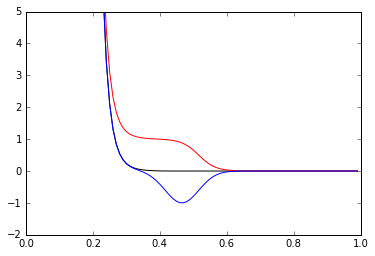

In [22]:
# plot one of the potentials with zero epsilon and what does it look like.
plot_pot = pairwise_potentials[0]
print "excluded_volume: %f   r0: %f   width: %f   epsilon: %f" % (plot_pot.rNC, plot_pot.r0, plot_pot.width, plot_pot.eps)

# a more itneresting demonstration is what does the potential look like with different epsilon values:

r_possible = np.arange(0.1, 1.0, 0.01)

# set a zero epsilon interaction
plot_pot.set_epsilon(0)
potential_zero = plot_pot.V(r_possible)

# set a repulsive interaction
plot_pot.set_epsilon(-1.) 
potential_negative = plot_pot.V(r_possible)

# set an attractive interaction
plot_pot.set_epsilon(1.)
potential_positive = plot_pot.V(r_possible)

plt.figure()
plt.plot(r_possible, potential_zero, color="k") # black curve
plt.plot(r_possible, potential_negative, color="r") # red curve
plt.plot(r_possible, potential_positive, color="b") # blue curve

plt.axis([0, 1, -2, 5])